The initial step in our
implementation is setting up the
environment, which includes
installing necessary Python libraries
such as `transformers` for accessing
the BERT model, `torch` for
handling tensors, `pandas` for data
manipulation, `matplotlib` for
plotting, and `BeautifulSoup` from
`bs4` for HTML parsing. This setup
ensures that all tools required for
processing, analyzing, and
visualizing data are readily
available.

In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch import no_grad
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os


In [2]:
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')


In [3]:
html_tables = {}
for table_name in os.listdir('datasets'):
    table_path = f'datasets/{table_name}'
    with open(table_path, 'r') as file:
        html = BeautifulSoup(file.read(), features="html.parser")
        html_table = html.find(id="news-table")
        html_tables[table_name] = html_table

parsed_news = []
for file_name, news_table in html_tables.items():
    for x in news_table.findAll('tr'):
        text = x.get_text() 
        headline = x.a.get_text()
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        ticker = file_name.split('_')[0]
        parsed_news.append([ticker, date, time, headline])


In [6]:
def sentiment_score(headline):
    tokens = tokenizer.encode(headline, return_tensors='pt')
    with no_grad():
        result = model(tokens)
        return int(torch.argmax(result.logits)) + 1

columns = ['ticker', 'date', 'time', 'headline']
scored_news = pd.DataFrame(parsed_news, columns=columns)
scored_news['sentiment'] = scored_news['headline'].apply(sentiment_score)


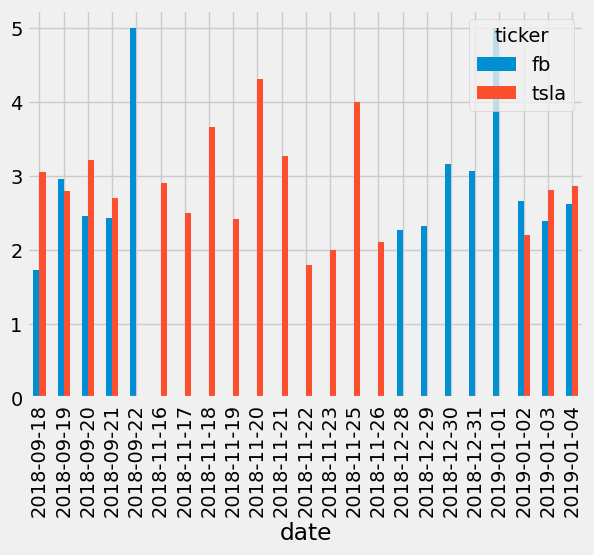

In [7]:
plt.style.use("fivethirtyeight")
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
mean_scores = scored_news.groupby(['date', 'ticker']).mean()
mean_scores = mean_scores.unstack(level=1)
mean_scores.xs('sentiment', axis=1).plot.bar()
plt.savefig('sentiment_bert.png', bbox_inches='tight')
